
# The Skip-gram model







## Word embeddings

The main goal of this problem is to create **word embeddings**, i.e., a mapping from words to a vector space. These vectors can indicate semantic similarities between words.
The two most popular algorithms for constructing word embeddings are **skip-gram** and **CBOW** (Continous Bag Of Words).
In both algorithms, word embeddings are learned through an auxiliary task. In CBOW, this task is predicting the current word from a window of **context** words, i.e., surrounding words. The auxiliary task under the skip-gram scheme is the opposite: given a current word, the task is predicting context words. After training, we use learned weights from the model as our word embeddings.



## Skip gram general architecture

*The global architecture of the base model of the skip-gram. Picture taken from [this website](https://www.geeksforgeeks.org/implement-your-own-word2vecskip-gram-model-in-python/)* 


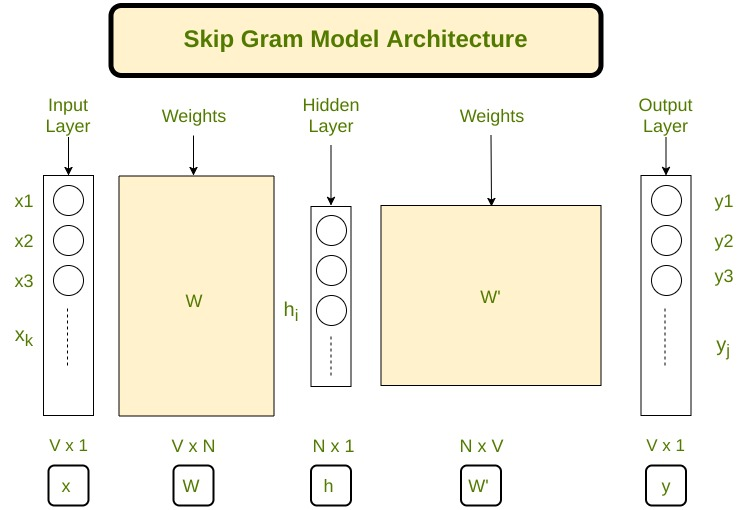


We consider a vocabulary of words $V$ for which we wish to create embeddings of dimension $N$, i.e., $\mathbf e_{wrd}(w) \in \mathbb{R}^N$. Additionally, we assume our skip-gram model considers the $T$ words preceding and following our input word in the prediction step.

The first step in the algorithm for training a skip-gram model is the processing of each sample in our training data into a (multi-) set of pairs of input and context words ($w_i$, $w_t$), where $t\in \{-T, -(T-1), \dots, T\}$ indicates the position of $w_t$ with respect to $w_i$ in the training sample. 

We project the *one-hot* encoding of our input word $\mathbf e_{oh}(w_i)\in \mathbb{R}^{|V|}$ with a weight matrix $W \in \mathbb{R}^{|V| \times N}$. This projection is then multiplied by weight matrix $W'$ and the softmax function is applied, resulting in a vector that represents the predicted probability of $w\in V$ appearing in the size $2T$ context window around word $w_i$. Our goal is to maximize the log-likelihood of our data: $\log p(w_t|w_i, W, W')$, which is typically done using gradient-descent methods.

At the end of training, we use the rows of matrix $W$ as our word embeddings, i.e., $\mathbf e_{wrd}(w_i) = W_i$.

Note: the columns of $W'$ will give us "context embeddings" $\mathbf e_{ctx}$, but we are only interested in the word embeddings.



## Negative sampling

During training, our goal is to maximize $$p(w_t\mid w_i)=\frac{1}{Z(w_i)}\exp(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t)) = \frac{1}{Z(w_i)}\exp(W_i \cdot (W')^\top_t)  $$

However $Z(w)=\sum_{w' \in V} \exp(\mathbf e_{wrd}(w) \cdot \mathbf e_{ctx}(w'))$ can take a long time to compute for large $V$.
We can instead use **negative sampling**: rather than computing the $|V|$-dimensional probability distribution via the softmax, we use the sigmoid function between the ground truth label and the label of a word drawn uniformly at random from $V$. 

Formally, for each pair of words in our training data $(w_i,w_t)$, we randomly sample (with replacement) a set $C^-$ from $V$. Our objective under the negative sampling approach becomes

 $$\underset{W,W'}{\text{arg max}} \sum_{(w_i,w_t,C^-)} \left(  \log(p(w_t\mid w_i)) +  \sum_{w \in C^-}  \log(1-p(w|w_i)) \right)$$

where we compute $p(w_t\mid w_i)$ using the sigmoid function: $p(w_t|w_i) = \sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t))$.


# Hyperparameters

In [9]:
V_size = 12000 #size of the vocabulary
N = 300 #embedding size
window_size = 5
K= 20 #number of negative samples per positive pairs (wt,wi)

# Data loading and preprocessing

In [2]:
import nltk
nltk.download('brown')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import brown
from nltk.corpus import stopwords 

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Karol\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\brown.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Karol\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Karol\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [3]:
sentences = brown.sents()
print(len(sentences))
print(sentences[:3])

57340
[['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['The', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.'], ['The', 'September-October', 'term', 'jury', 'had', 'been', 'charged', 'by', 'Fulton', 'Superior', 'Court', 'Judge', 'Durwood', 'Pye', 'to', 'investigate', 'reports', 'of', 'possible', '``', 'irregularities', "''", 'in', 'the', 'hard-fought', 'primary', 'which', 'was', 'won', 'by', 'Mayor-nominate', 'Ivan', 'Allen', 'Jr.', '.']]


In [4]:
import string
stop_words = set(stopwords.words('english')) 
def preprocessing(sentences): 
    training_data = [] 
    for i in range(len(sentences)): 
        #sentences[i] = sentences[i].strip() 
        sentence = sentences[i] 
        x = [word.strip(string.punctuation) for word in sentence] 
        x = [word.lower() for word in x] 
        x = [word for word in x if word!='' and word.isalpha()]
        x = [word for word in x if word not in stop_words]
        if x:
          training_data.append(x) 
    return training_data 
sentences = preprocessing(sentences)
print(sentences[:3])

[['fulton', 'county', 'grand', 'jury', 'said', 'friday', 'investigation', 'recent', 'primary', 'election', 'produced', 'evidence', 'irregularities', 'took', 'place'], ['jury', 'said', 'presentments', 'city', 'executive', 'committee', 'charge', 'election', 'deserves', 'praise', 'thanks', 'city', 'atlanta', 'manner', 'election', 'conducted'], ['term', 'jury', 'charged', 'fulton', 'superior', 'court', 'judge', 'durwood', 'pye', 'investigate', 'reports', 'possible', 'irregularities', 'primary', 'ivan', 'allen', 'jr']]


# Prepare data for training


## Extract V

In [5]:
from collections import defaultdict
count = defaultdict(int)
for sentence in sentences: 
    for word in sentence: 
      count[word] += 1

In [7]:
import operator
sorted_counts = sorted(count.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_counts[:10])

[('one', 3297), ('would', 2714), ('said', 1961), ('new', 1635), ('could', 1601), ('time', 1598), ('two', 1412), ('may', 1402), ('first', 1361), ('like', 1292)]


Select the V most commons

In [10]:
vocabulary = sorted_counts[:V_size]

## Convert the corpus into indices

Many of our operations can be vectorized if we represent our words with unique ids rather than the original string. 

We assign an id to all words and create lookup tables for word to index and index to word for fast lookup. For the rest of the problem, you will work with these indices.

In [11]:
# Assign ids and create lookup tables
word_to_index = {'UNK': 0}
index_to_word = ['UNK']
for idx, tup in enumerate(vocabulary,1):
  word_to_index[tup[0]] = idx
  index_to_word.append(tup[0])

In [12]:
assert len(index_to_word) == len(word_to_index)
print(len(index_to_word))

12001


Now we can transform our dataset by replacing the words with their index.

In [13]:
sentences_index = []
for sent in sentences:
  ids=[]
  for word in sent:
    if word in word_to_index:
      ids.append(word_to_index[word])
    else: 
      ids.append(0)
  sentences_index.append(ids)
print(sentences_index[:3])

[[5128, 513, 2100, 1459, 3, 1655, 1982, 419, 959, 1231, 1027, 343, 8702, 95, 59], [1459, 3, 0, 118, 1836, 467, 713, 1231, 5373, 5129, 2730, 118, 2881, 702, 1231, 1837], [1202, 1459, 1769, 5128, 2197, 287, 1232, 0, 0, 7058, 1117, 136, 8702, 959, 0, 4520, 1262]]


Here you go ! We have preprocessed the corpus. Now it's your turn to implement the rest of the notebook, in order to extract samples, train the model and analyze the embeddings you obtain.

## Extract pair (word, context)

**Task 1.a.** : Create a list of training samples $C$: for each word $w_i$ in the corpus, add a tupple ($w_i$, $w_t$) for each context word $w_t$ in $w_i$'s context window.

Remember we defined the parameters window_size in the beginning of this notebook.

In [14]:
#Solution task 1.a.
training_samples = []
for sentence in sentences_index:
    for i, word in enumerate(sentence):
        for j in range(i - window_size, i + window_size):
            if i != j and j >= 0 and j < len(sentence):
                training_samples.append((word, sentence[j]))
print(len(training_samples))
print(training_samples[:10])
        

3306977
[(5128, 513), (5128, 2100), (5128, 1459), (5128, 3), (513, 5128), (513, 2100), (513, 1459), (513, 3), (513, 1655), (2100, 5128)]


## Negative sampling



**Task 1.b.**: Create negative samples: for each positive sample ($w_i$, $w_t$) in $C$, we want to create a set $C^-$ of $K$ negative samples. We sample a word proportional to its number of occurences in the corpus and the negative samples should be different from the positive context word $w_t$. Store all the training data as a list of tuple ($w_i$, $w_t$, $C^-$)

In [ ]:
#Solution task 1.b.

import numpy as np
z = np.sum([v[1] for v in vocabulary])
vocab_dict = dict([(word_to_index[v[0]], v[1]) for v in vocabulary])
for i, sample in enumerate(training_samples):
    vocab_dict_temp = vocab_dict.copy()
    vocab_dict_temp.pop(sample[0], None)
    word_list = list(vocab_dict_temp.keys())
    proba_list = list(vocab_dict_temp.values())
    z = sum(proba_list)
    proba_list = [p/z for p in proba_list]
    negative_samples = np.random.choice(word_list,
                                        size=K, 
                                        replace=True, 
                                        p=proba_list)
    training_samples[i] = (sample[0], sample[1], negative_samples)
    if i % 10000 == 0:
        print(i, end=' ')
print(len(training_samples))

# Learning

## Calculate gradient

Recall our training objective under the negative sampling approach. Under this objective, we can define our loss function with respect to our training data $\mathcal{D}$ as:

$$L(W,W') =-\sum_{(w_i,w_t,C^-) \in \mathcal{D}}\left (\log(\sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t))) +  \sum_{w \in C^-}  \log(1-\sigma(\mathbf e_{wrd}(w_i) \cdot e_{ctx}(w)))\right )$$

**Task 2.a.** : Write down the partial derivative of the loss with respect to the word embedding $\mathbf e_{wrd}(w_i)$ and context embedding $\mathbf e_{ctx}(w_t)$. Additionally, provide the partial derivative of the loss with respect to a single negative sample $w^- \in C^-$: $\nabla_{\mathbf e_{wrd}(w_i)} L$, $\nabla_{\mathbf e_{ctx}(w_t)} L$, $\nabla_{\mathbf e_{ctx}(w^-)} L$


$\nabla_{\mathbf e_{wrd}(w_i)} L=-\sum_{(w_i,w_t,C^-) \in \mathcal{D}}(\mathbf e_{ctx}(w_t)\cdot(1- \sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t)))-\sum_{w^- \in C^-}( \mathbf e_{ctx}(w^-)\cdot\sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w^-))))$

$\nabla_{\mathbf e_{ctx}(w_t)} L=-\sum_{(w_i,w_t,C^-) \in \mathcal{D}}(\mathbf e_{wrd}(w_i)\cdot(1- \sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w_t))))$

$\nabla_{\mathbf e_{ctx}(w^-)} L=\sum_{(w_i,w_t,C^-) \in \mathcal{D}}(\mathbf e_{wrd}(w_i)\cdot(\sigma(\mathbf e_{wrd}(w_i) \cdot \mathbf e_{ctx}(w^-))))$

**Task 2.b** : Write down the formula of the gradient update of $\mathbf e_{wrd}(w_i)$, $\mathbf e_{ctx}(w_t)$ and $\mathbf e_{ctx}(w^-)$.

**Solution task 2.b. :**

$\mathbf e_{wrd}(w_i) = \mathbf e_{wrd}(w_i)-\eta\nabla_{\mathbf e_{wrd}(w_i)} L$

$\mathbf e_{ctx}(w_t) = \mathbf e_{ctx}(w_t)-\eta\nabla_{\mathbf e_{ctx}(w_t)} L$

$\mathbf e_{ctx}(w^-) = \mathbf e_{ctx}(w^-)-\eta\nabla_{\mathbf e_{ctx}(w^-)} L$


## Training

**Task 3 :** With the dataset of positive and negative samples you created, implement the gradient descent algorithm. You have to initialize the matrices W and W' with random weights between -0.8 and 0.8, compute the gradients efficiently and launch the training on several epochs. Draw the curve of the loss in function of the total number of steps.

In [ ]:
#training params
lr = 0.03
epochs = 10

In [ ]:
#Solution task 3
W = np.random.uniform(-0.8, 0.8, (V_size+1, N))
W1 = np.random.uniform(-0.8, 0.8, (N, V_size+1))

In [ ]:
import matplotlib.pyplot as plt

losses = []

def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s

def gradientDescent(W, W1, sample, lr):
    h = W[sample[0]]
    contextPos = sample[1]
    contextNeg = sample[2]
    
    cost = 0
    sigm = sigmoid(np.dot(h, W1[:,  contextPos]))
    if sigm:
        cost = -1.0 * np.log(sigm)
        dW = -1 * W1[:, contextPos] * (1.0 - sigm)
        dW1_pos = -1 * h * (1.0 - sigm)
    
    for i in contextNeg:
        sigm = sigmoid(np.dot(h, W1[:, i]))
        if sigm == 1.0:
            continue
        cost -= np.log(1.0 - sigm)
        dW += W1[:, i] * sigm
        dW1_neg = h * sigm
        W1[:, i] -= lr * dW1_neg
        
    W[sample[0]] -= lr * dW
    W1[:, contextPos] -= lr * dW1_pos
        
    return cost

for epoch in range(epochs):
    print('epoch', epoch+1, '/', epochs)
    epoch_loss = 0
    n = len(training_samples)
    for i in range(n):
        sample = training_samples[np.random.randint(n)]
        cost = gradientDescent(W, W1, sample, lr)
        epoch_loss += cost
        
    losses.append(epoch_loss / len(training_samples))
    print('loss', epoch_loss / len(training_samples))

np.save('W.npy', W)
np.save('W1.npy', W1)
print(losses)
plt.plot([x for x in range(1, epochs + 1)], losses)
plt.show()

Now you can use the matrix W for words embeddings.

We recommend you to save your embedding matrix for the rest of the problem. You have to hand it in with your assignment so that we can reproduce your results.

# Analyzing the embeddings

## Cosine similarity calculation

One way to compare vectors is the cosine similarity, which is defined as :
$$sim(\mathbf x,\mathbf y) = \frac{\mathbf x \cdot \mathbf y}{||\mathbf x|| ||\mathbf y||}$$

**Task 4.a.** : Fill the tables with the cosine similarity between the given words and comment the results :


| x      | y       | sim(x,y)     | 
|--------|---------|--------------|
|film    |movie    |  0.12        |
|film    |water    |  0.15        |
|home    |house    |  0.24        |
|home    |yellow   |  0.05        |
|father  |mother   |  0.25        |
|father  |street   |  0.11        |
|street  |avenue   |  0.28        |
|writer  |poet     |  0.21        |
|writer  |potatoes | -0.03       |
|boy     |girl     |  0.32        |
|children|young    |  0.27        |
|children|old      |  0.11        |
|eat     |food     |  0.20        |
|eat     |sport    |  0.07        |
|water   |liquid   |  0.27        |
|water   |solid    |  0.08        |








In [16]:
import numpy as np
W = np.load('W.npy')
W1 = np.load('W.npy')


def cos_similarity(v1, v2):
    numerator = np.dot(v1, v2)
    denom = np.linalg.norm(v1) * np.linalg.norm(v2)
    return numerator / denom
    
x = ['film', 'film', 'home', 'home', 'father', 'father', 'street', 'writer', 
     'writer', 'boy', 'children', 'children', 'eat', 'eat', 'water', 'water']
y = ['movie', 'water', 'house', 'yellow', 'mother', 'street', 'avenue', 'poet', 
     'potatoes', 'girl', 'young', 'old', 'food', 'sport', 'liquid', 'solid']

for w1, w2 in zip(x, y):
    n1 = word_to_index[w1]
    n2 = word_to_index[w2]
    print(w1, w2, cos_similarity(W[n1], W[n2]))

film movie 0.12051203475564815
film water 0.14649449328524353
home house 0.23726485170332048
home yellow 0.049870582532764426
father mother 0.2515940272282796
father street 0.10534262838091699
street avenue 0.27894810996639685
writer poet 0.20814624696420442
writer potatoes -0.0027438748625330505
boy girl 0.3227978117457345
children young 0.27088549730238526
children old 0.112015580201248
eat food 0.20482174785197874
eat sport 0.06747319641186678
water liquid 0.2660776723449423
water solid 0.07745088465436036


**Task 4.b.** Show the 10 nearest words of the following words with the associated cosine similarity values : [*love, car, president, monday, green, money, health, faith, book, france, swiss, spring*] along with 5 words of your choice. Provide a brief description of your observations.



In [17]:
def find_n_nearest(word, n, W):
    distances = []
    v1 = W[word_to_index[word]]
    for w in index_to_word:
        if word == w:
            continue
        v2 = W[word_to_index[w]]
        distances.append([w, cos_similarity(v1, v2)])
        if w == 'car':
            print(cos_similarity(v1, v2))
    distances.sort(key=lambda a: a[1], reverse=True)
    return distances[:n]
    
words = ['love', 'car', 'president', 'monday', 'green', 'money', 'health', 'faith', 'book', 'france', 'swiss', 'spring']
for word in words:
    analogies = find_n_nearest(word, 10, W)
    print('Analogies for "{}":'.format(word))
    for n in analogies:
        print(n)
    print()

0.10612815876703326
Analogies for "love":
['god', 0.3163381792679176]
['compelled', 0.307119334819255]
['amazed', 0.29780188960657783]
['moist', 0.29756945913662153]
['word', 0.2936226237062982]
['johnnie', 0.28976964717513437]
['spirit', 0.2840671205365534]
['fallen', 0.28230963330002373]
['understand', 0.28025605122131697]
['inspired', 0.2792233030265643]

Analogies for "car":
['cars', 0.3535084373458514]
['parked', 0.33021137011064094]
['flashlight', 0.3182632222016434]
['driving', 0.31538906115202087]
['driveway', 0.30670161543867036]
['hotel', 0.3052016563977941]
['slid', 0.3048158450794454]
['spot', 0.3046421670574938]
['headlights', 0.3017040851194136]
['back', 0.30088330980235206]

0.15460941858143964
Analogies for "president":
['vice', 0.4139242271293032]
['kennedy', 0.3891803983491297]
['secretary', 0.3275264760437434]
['berlin', 0.32227696427695673]
['faculty', 0.32198114676385764]
['adlai', 0.3097112910101733]
['rev', 0.30858058838741764]
['requested', 0.3081346293708327]
[

Most of the analogies are closely related to the given word. In most of the sets there are single not-related words, what is typical for word2vec algorithm.  

## Words analogies

**Task 5** : As explained in class, we can also evaluate word embeddings with word analogies.
Compare the cosine similarities between following vectors and comment on the results. Find 2 other such examples.

| x                            | y       | sim(x,y)     | 
|------------------------------|---------|--------------|
|london - england + germany    | berlin  |    0.24      |
|father - man + woman          |mother   |    0.15      |
|children - young + old        |parents  |    0.17      |
|sister - girl + boy           |brother  |    0.16      |
|happiness - good + bad        |pain     |    0.18      |


In [18]:
v1 = W[word_to_index['london']] - W[word_to_index['england']] + W[word_to_index['germany']]
v2 = W[word_to_index['berlin']]
print('london-england+germany, berlin:', cos_similarity(v1, v2))

v1 = W[word_to_index['father']] - W[word_to_index['man']] + W[word_to_index['woman']]
v2 = W[word_to_index['mother']]
print('father-man+woman, mother:', cos_similarity(v1, v2))

v1 = W[word_to_index['children']] - W[word_to_index['young']] + W[word_to_index['old']]
v2 = W[word_to_index['parents']]
print('children-young+old, parents:', cos_similarity(v1, v2))

v1 = W[word_to_index['sister']] - W[word_to_index['girl']] + W[word_to_index['boy']]
v2 = W[word_to_index['brother']]
print('sister-girl+boy, brother:', cos_similarity(v1, v2))

v1 = W[word_to_index['happiness']] - W[word_to_index['good']] + W[word_to_index['bad']]
v2 = W[word_to_index['pain']]
print('happiness-good+bad, pain:', cos_similarity(v1, v2))

v1 = W[word_to_index['king']] - W[word_to_index['man']] + W[word_to_index['woman']]
v2 = W[word_to_index['queen']]
print('king-man+woman, queen:', cos_similarity(v1, v2))

v1 = W[word_to_index['fat']] - W[word_to_index['big']] + W[word_to_index['small']]
v2 = W[word_to_index['skinny']]
print('fat-big+small, skinny:', cos_similarity(v1, v2))

london-england+germany, berlin: 0.2361225439307264
father-man+woman, mother: 0.15497494473697873
children-young+old, parents: 0.17258618153972988
sister-girl+boy, brother: 0.15702402886663733
happiness-good+bad, pain: 0.1816784241021852
king-man+woman, queen: 0.14168940574811306
fat-big+small, skinny: 0.12832285871828844


# Visualization

**t-distributed stochastic neighbor embedding ([t-SNE](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf))** is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two or three-dimensional map.




The following code transforms the embeddings of W from dimension N to dimension 2.

In [20]:
from sklearn.manifold import TSNE

labels = []
tokens = []

for i in range(len(index_to_word)):
    tokens.append(W[i,:])
    labels.append(index_to_word[i])

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)


**Task 6** : Plot 3 graphs with the 2D coordinates of the first 100, 500 and 1000 words with their labels. Analyze the results, in particular identify some thematic clusters that your visualizations reveal.

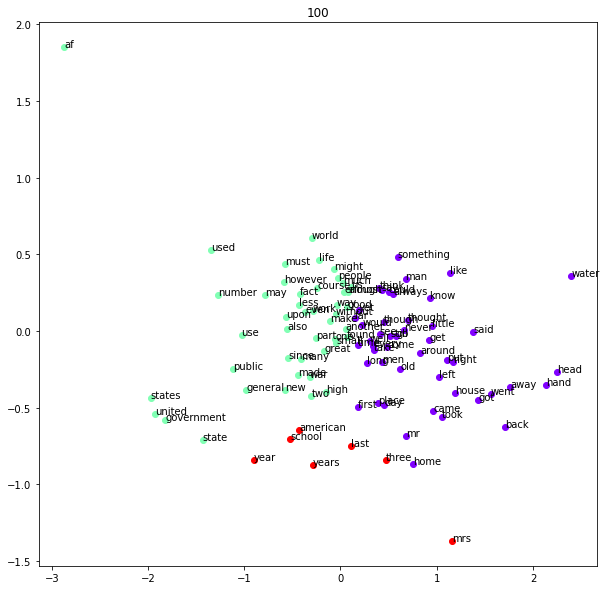

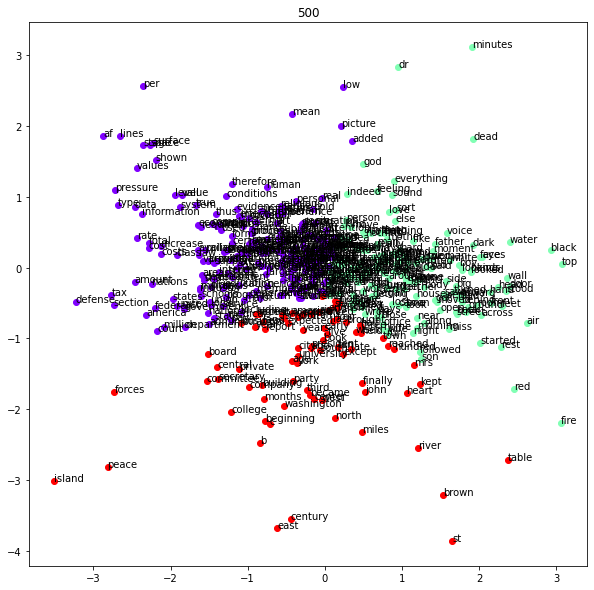

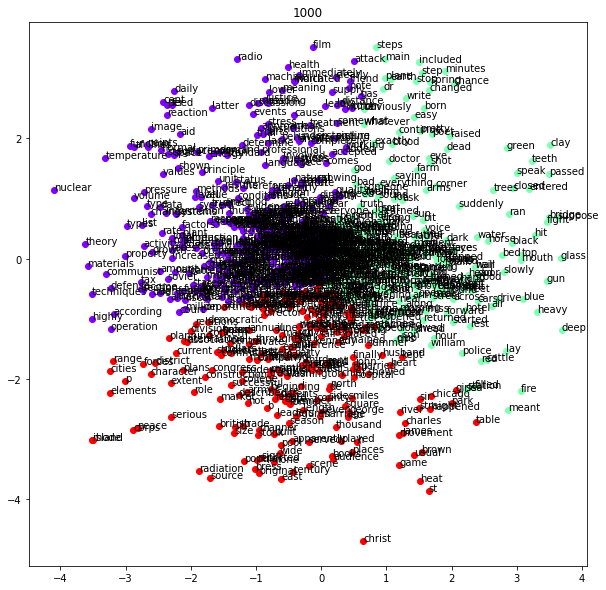

In [25]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def visualize(data, labels, z, clusters):
    colors = cm.rainbow(np.linspace(0, 1, clusters))
    kmeans = KMeans(n_clusters=clusters).fit(data)
    fig, ax = plt.subplots(figsize=(10, 10))
    for i in range(1, z):
        cls = kmeans.predict(data[i].reshape(1, 2))[0]
        x = data[i, 0]
        y = data[i, 1]
        ax.scatter(x, y, color=colors[cls])
        # if i%(z/5)==0:
        ax.annotate(labels[i], (x, y))
    plt.title(str(z))
    plt.show()
    

visualize(new_values, labels, 100, 3)
visualize(new_values, labels, 500, 3)
visualize(new_values, labels, 1000, 3)